In [1]:
import pandas as pd, numpy as np, os
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['font.size'] = 11
mpl.rcParams['grid.alpha'] = 0
mpl.rcParams['lines.linewidth'] = 3
pd.options.display.max_columns=1000
pd.options.display.max_rows=1000

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data_shoppe_for_nak.txt.gz',
 'PCT_EL_Shopee.ipynb',
 'shopee_seller_loan_detail_20221209.csv',
 'Untitled.ipynb']

In [3]:
loan = pd.read_csv("shopee_seller_loan_detail_20221209.csv", sep=",")
loan["key"] = loan[["ip_id","ar_id"]].astype(str).apply(lambda x:"_".join(x),axis=1)
loan.drop(columns=["ip_id", "ar_id"], inplace=True)

In [4]:
loan.head(3)

,pos_dt,nxt_pymt_dt,opn_dt,dsbr_dt,first_pymt_dt,mob,dlq_dys,spcl_prj_cd,lmt_amt,otsnd_bal,eff_int_rate_tp_cd,eff_rate_pct,eff_sprd_rate_pct,mat_dt,ctr_ar_term,ctr_ar_term_uom_tp_cd,rn,ptn_date,key
0,2022-12-08 00:00:00,2022-12-31 00:00:00,2021-12-11 00:00:00,2021-12-11 00:00:00,2021-12-31 00:00:00,12.0,69,SHPG10,160000.0,147840.56,8,18.13,12.03,2026-12-11 00:00:00,60,M,1,2022-12-08,1191957_100046477159
1,2022-12-08 00:00:00,2022-12-31 00:00:00,2022-01-07 00:00:00,2022-01-07 00:00:00,2022-01-31 00:00:00,11.0,8,SHPG10,120000.0,106517.92,8,18.13,12.03,2027-01-07 00:00:00,60,M,1,2022-12-08,24456331_100047124608
2,2022-12-08 00:00:00,2022-12-31 00:00:00,2022-06-02 00:00:00,2022-06-02 00:00:00,2022-06-30 00:00:00,6.0,0,SHPG10,100000.0,93206.78,8,21.13,15.03,2027-06-01 00:00:00,60,M,1,2022-12-08,17170302_100051565384


Kasikornbank	
- MOR=6.34	
- MLR=5.97	
- MRR=6.10

**Check**
- why otsnd_bal > lmt_amt ?
- What eff_int_rate_tp_cd = 11 is ?

In [5]:
def installment(p, r, mth, decimal=0):
    return np.round(p*r/(1-(1/(1+r)**mth)),decimal)

In [6]:
loan.loc[loan["eff_rate_pct"]==0,"eff_rate_pct"] = loan["eff_rate_pct"].mean()
loan["m_rate"] = loan["eff_rate_pct"]/12/100
loan["instl_amt"]   = loan[["lmt_amt","m_rate","ctr_ar_term"]].apply(lambda x:installment(*x),axis=1)
loan["tot_pmt_amt"] = loan["instl_amt"] * loan["ctr_ar_term"]

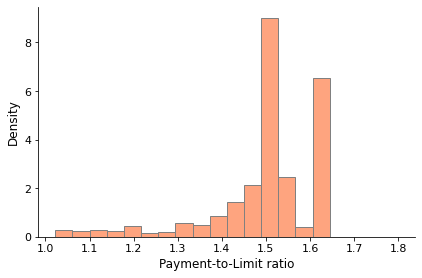

In [29]:
plt.hist(np.clip(loan["tot_pmt_amt"]/loan["lmt_amt"],0,1.8), 
         bins=20, density=True, ec="grey", color="#FEA47F")
plt.xlabel("Payment-to-Limit ratio", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.tight_layout()

## Rules
$RAROC = \frac{Revenue - Expense - ROC - EL}{EC}$
- ROC : BIBOR (1Y) = 1.89643%
- Expense : Fixed deposit (1Y) = 0.70%

In [13]:
X = pd.read_csv('data_shoppe_for_nak.txt.gz', low_memory=True, sep="|")
X["fg_rule0"] = 1
X = X.loc[X["opn_mth"]<=202206].reset_index(drop=True)

In [14]:
X = X.merge(loan[["key","m_rate","instl_amt",
                  "ctr_ar_term","tot_pmt_amt"]], on="key", how="left")

In [15]:
dok = ["n_app","n_60+M4","n_NPL",
       "a_app","a_60+M4","a_NPL", 
       "eff_rate", "revenue", "n_terms"]
dok = {key:[] for key in dok}

f60 = X["f60+M04"].values
f90 = X["f90+ever"].values
os  = X["lmt_amt"].values
efr = X["m_rate"].values
pmt = X["tot_pmt_amt"].values
ctr = X["ctr_ar_term"].values
factor = 1/10**6

for n in range(10):
    rule = X[f"fg_rule{n}"].values
    dok["n_app"] += [rule.sum()]
    dok["a_app"] += [os[rule==1].sum()*factor]
    
    dok["n_60+M4"] += [np.nansum(f60[rule==1])]
    dok["a_60+M4"] += [os[(rule + f60)==2].sum()*factor]
    dok["n_NPL"]   += [np.nansum(f90[rule==1])]
    dok["a_NPL"]   += [os[(rule + f90)==2].sum()*factor]
    
    dok["revenue"]  += [pmt[rule==1].sum()*factor]
    dok["eff_rate"] += [efr[rule==1].mean()*12]
    dok["n_terms"]  += [ctr[rule==1].mean()]

In [74]:
a = pd.DataFrame(dok)
a["%app"]   = a["n_app"]/max(a["n_app"])
a["%n_NPL"] = a["n_NPL"]/a["n_app"]
a["%a_NPL"] = a["a_NPL"]/a["a_app"]

In [75]:
np.round(a.astype(float),4)

,n_app,n_60+M4,n_NPL,a_app,a_60+M4,a_NPL,eff_rate,revenue,n_terms,%app,%n_NPL,%a_NPL
0,344577.0,38066.0,83889.0,81922.211,8516.493,23706.635,0.1773,122533.8938,56.6508,1.0000,0.2435,0.2894
1,326022.0,33943.0,78743.0,80985.263,8312.592,23448.593,0.1764,121070.3893,56.5428,0.9462,0.2415,0.2895
2,293207.0,27239.0,69896.0,77736.132,7622.730,22498.993,0.1747,116010.4477,56.2640,0.8509,0.2384,0.2894
3,225181.0,15598.0,50329.0,55459.074,3817.032,15014.840,0.1719,82168.6267,55.3320,0.6535,0.2235,0.2707
4,201381.0,11936.0,44965.0,52111.393,3268.073,14154.653,0.1700,76999.4023,54.9477,0.5844,0.2233,0.2716
5,185702.0,9721.0,40741.0,47193.165,2572.382,12686.314,0.1689,69526.6073,54.5850,0.5389,0.2194,0.2688
6,174650.0,8281.0,37843.0,42170.782,1922.367,11263.143,0.1685,62015.2039,54.3142,0.5069,0.2167,0.2671
7,161174.0,6686.0,34248.0,38596.752,1529.214,10202.179,0.1674,56574.7400,53.9659,0.4677,0.2125,0.2643
8,144631.0,5109.0,31204.0,34777.330,1140.953,9301.881,0.1657,50797.3047,53.4816,0.4197,0.2157,0.2675
9,126429.0,3575.0,27744.0,31960.676,900.610,8725.462,0.1633,46503.4484,52.8892,0.3669,0.2194,0.2730


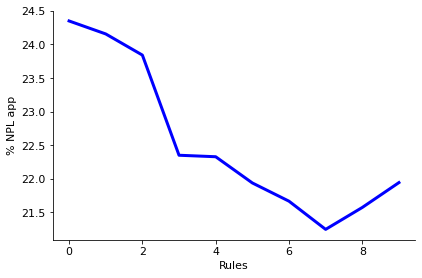

In [18]:
plt.plot(a["%n_NPL"]*100, c="blue")
plt.ylabel("% NPL app")
plt.xlabel("Rules")
plt.tight_layout()

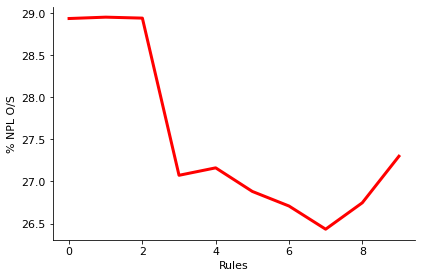

In [19]:
plt.plot(a["%a_NPL"]*100, c="red")
plt.ylabel("% NPL O/S")
plt.xlabel("Rules")
plt.tight_layout()

## Method 1: Amount

In [88]:
def EcoCapital(mean, std, p=99, os=1, random_state=0, bins=30):
    
    rnd = np.random.RandomState(random_state)
    losses   = rnd.normal(mean, std, size=10000)-1
    losses   = np.clip(losses, 0, 1) * os
    exp_loss = np.mean(losses)
    max_pct  = np.percentile(losses, p)
    capital  = max_pct - exp_loss
 
    ax = plt.subplots(1,1)[1]
    ax.hist(losses, bins=bins, ec="grey", 
            color="#FEA47F", density=True)
    label = "EL(x=0.50) = {:,.2f}".format(exp_loss)
    ax.axvline(exp_loss, ls="--", lw=1, c="b", label=label)
    label = "EL(x={:.2f}) = {:,.2f}".format(p,max_pct)
    ax.axvline(max_pct, ls="--", lw=1, c="k", label=label)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlabel("Loss", fontsize=12)
    ax.set_title("Economic Capital = {:,.2f}".format(capital))
    ax.legend(loc="best", fontsize=12)
    ax.set_ylim(0, ax.get_ylim()[1]/0.7)
    plt.tight_layout()
    return ax

In [84]:
p = X["f90+ever"].mean()
np.sqrt((1-p)*p)

0.42916741791713775

In [87]:
def cal_ecocap(pd_mean, pd_std, p=99, os=1, random_state=0):
    rnd = np.random.RandomState(random_state)
    losses   = rnd.normal(mean, std, size=10000)-1
    losses   = np.clip(losses, 0, 1) * os
    exp_loss = np.mean(losses)
    max_pct  = np.percentile(losses, p)
    capital  = max_pct - exp_loss
    return capital

<AxesSubplot:title={'center':'Economic Capital = 0.23'}, xlabel='Loss', ylabel='Density'>

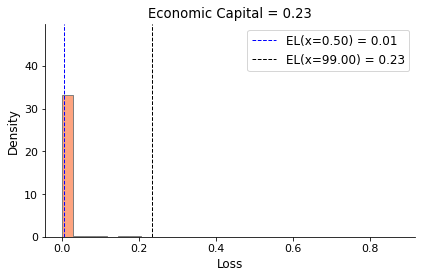

In [89]:
EcoCapital(p, 0.429, os=1)

(array([1.700e+01, 6.700e+01, 3.040e+02, 7.370e+02, 1.302e+03, 1.618e+03,
        1.673e+03, 1.548e+03, 1.059e+03, 7.690e+02, 4.230e+02, 2.330e+02,
        1.280e+02, 6.800e+01, 3.000e+01, 1.300e+01, 5.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

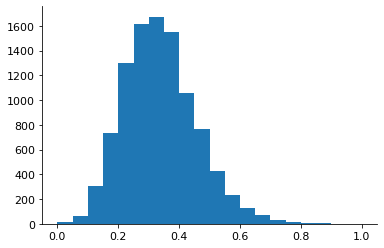

In [156]:
rnd = np.random.RandomState(20)
p = 0.03
a = rnd.lognormal(p, np.sqrt((1-p)*p), size=10000)
c = (a - min(a))/(max(a)-min(a))
plt.hist(c, bins=20)

In [160]:
a = X[["opn_mth","f90+ever","lmt_amt"]].copy()
a["EAD"] = np.where(a["f90+ever"]==0,0,a["lmt_amt"])
a

,opn_mth,f90+ever,lmt_amt,EAD
0,202203,0,1000000.0,0.0
1,202203,0,1000000.0,0.0
2,202203,0,1000000.0,0.0
3,202203,0,1000000.0,0.0
4,202203,0,1000000.0,0.0
...,...,...,...,...
344572,202112,0,88000.0,0.0
344573,202112,0,88000.0,0.0
344574,202112,0,88000.0,0.0
344575,202112,0,88000.0,0.0


In [154]:
np.sqrt(a["ff"].values.sum())

188423.3054138549

In [112]:
np.std(a)

0.0071336448530108995

In [129]:
(1-0.02)*0.02

0.0196

In [128]:
loan["otsnd_bal"].sum()/loan["lmt_amt"].sum()

0.9542953456475972

In [135]:
sigma = np.diagflat([2.5,1.8,4.8])
rho  = np.diagflat([1,1,1])

In [138]:
sigma.dot(sigma).su

array([[ 6.25,  0.  ,  0.  ],
       [ 0.  ,  3.24,  0.  ],
       [ 0.  ,  0.  , 23.04]])

In [153]:
np.sqrt((sigma**2).sum())

5.70350769263968

In [145]:
np.where(rho==0,0.5,rho)


array([[1. , 0.5, 0.5],
       [0.5, 1. , 0.5],
       [0.5, 0.5, 1. ]])

In [168]:
1671*0.51

852.21

In [166]:
6087-167

5920

In [164]:
5920/18933

0.08825859610204405

In [167]:
5920/18993

0.31169378191965463